# Chapter 03 — Loading AnnDatas and Plotting Basic Metrics

## Objective

In this chapter, we load all single-nucleus RNA-seq datasets required for benchmarking the **Singulator + FACS** and **Singulator + LeviCell** protocols. We also verify metadata consistency, perform basic integrity checks, and prepare the data objects for downstream analysis.

This includes:

- Locating the data on the shared filesystem (Iris)
- Loading raw count matrices (e.g., `filtered_feature_bc_matrix.h5` from 10X)
- Loading data into `AnnData` objects

## Data Source

The data for this benchmarking project is stored on the **Iris** HPC filesystem under:

`/data1/collab002/sail/isabl/datalake/prod/010/collaborators/SAIL/projects/singulator_debris_removal_and/experiments`

We will be working with the data under identifier `MB-4027_*`


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Core Imports

In [16]:
import os
import scanpy as sc
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List
import utils

## File Paths and Metadata

In [17]:
# Constants
DATA_DIR = "./data"
FIGURES_OUTPUT_DIR = "./figures/chapter_06_downsampled_basic_analysis"

GENE_SETS_DIR = os.path.join(DATA_DIR, "gene_sets_and_info")
FILTERED_FEATURE_BC_MATRIX_FILE_NAME = "filtered_feature_bc_matrix.h5"

ADATA_DIR = os.path.join(DATA_DIR, "analysis", "adatas")

INPUT_ADATA_DIR = os.path.join(
    ADATA_DIR, "adatas_X_filtered_cells_raw_with_downsampled_layer"
)
OUTPUT_ADATA_DIR = os.path.join(
    ADATA_DIR, "adatas_X_downsampled_with_gene_metrics"
)

# Make sure output directories exist
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_ADATA_DIR, exist_ok=True)

# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

### Read in AnnDatas

In [18]:
# Load AnnData objects
adatas = {}
adata_metadata = {}
adata_tissues = []

for key, (folder, tissue, protocol) in samples.items():
    file_path = os.path.join(INPUT_ADATA_DIR, f"{key}_adata.h5ad")
    adata = sc.read_h5ad(file_path)
    adata.layers["raw_data"] = adata.X
    adata.X = adata.layers["downsampled_umi"]
    sc.pp.filter_cells(adata, min_counts=1)
    adatas[key] = adata
    adata_metadata[key] = (tissue, protocol)
    adata_tissues.append(tissue)
    print(f"{key}: {adata}")

SF_N: AnnData object with n_obs × n_vars = 7179 × 32527
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'downsampled_umi', 'raw_data'
SL_N: AnnData object with n_obs × n_vars = 7929 × 33481
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'downsampled_umi', 'raw_data'
SF_T: AnnData object with n_obs × n_vars = 7146 × 31710
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_

## Generate Plots

### Read in Downsampled Filtered Molecule Infos

In [19]:
downsampled_mol_infos = {}
downsampled_mol_info_metadata = {}

for key, (folder, tissue, protocol) in samples.items():
    file_path = os.path.join(DATA_DIR, "analysis", key, f"{key}_downsampled_molecule_info.parquet")
    downsampled_mol_info = pl.read_parquet(file_path)
    downsampled_mol_infos[key] = downsampled_mol_info
    downsampled_mol_info_metadata[key] = (tissue, protocol)

### Plot Total Number of Reads

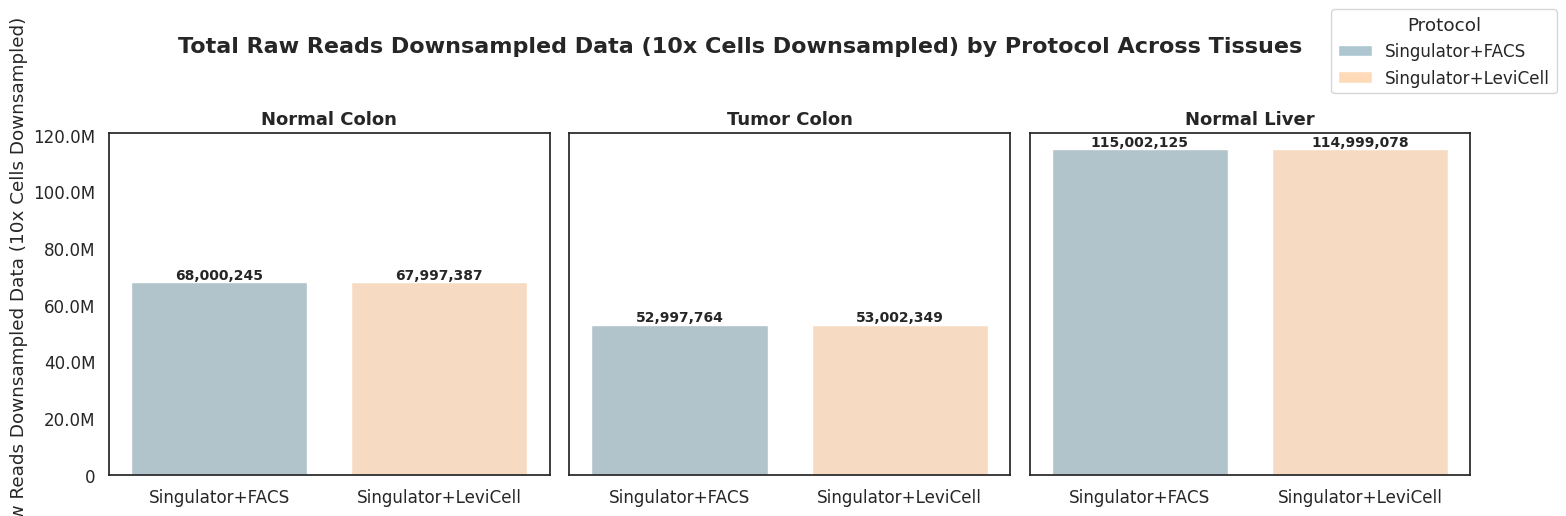

In [20]:
# Plot the total reads per sample for all droplets
fig = utils.plot_scalar_metric(
    data_dict=downsampled_mol_infos,
    metadata=downsampled_mol_info_metadata,
    metric_func=lambda df: df["reads"].sum(),  # Total reads per sample
    metric_label="Total Raw Reads Downsampled Data (10x Cells Downsampled)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "downsampled_total_raw_reads_all_droplets.png"),
    bbox_inches="tight",
)

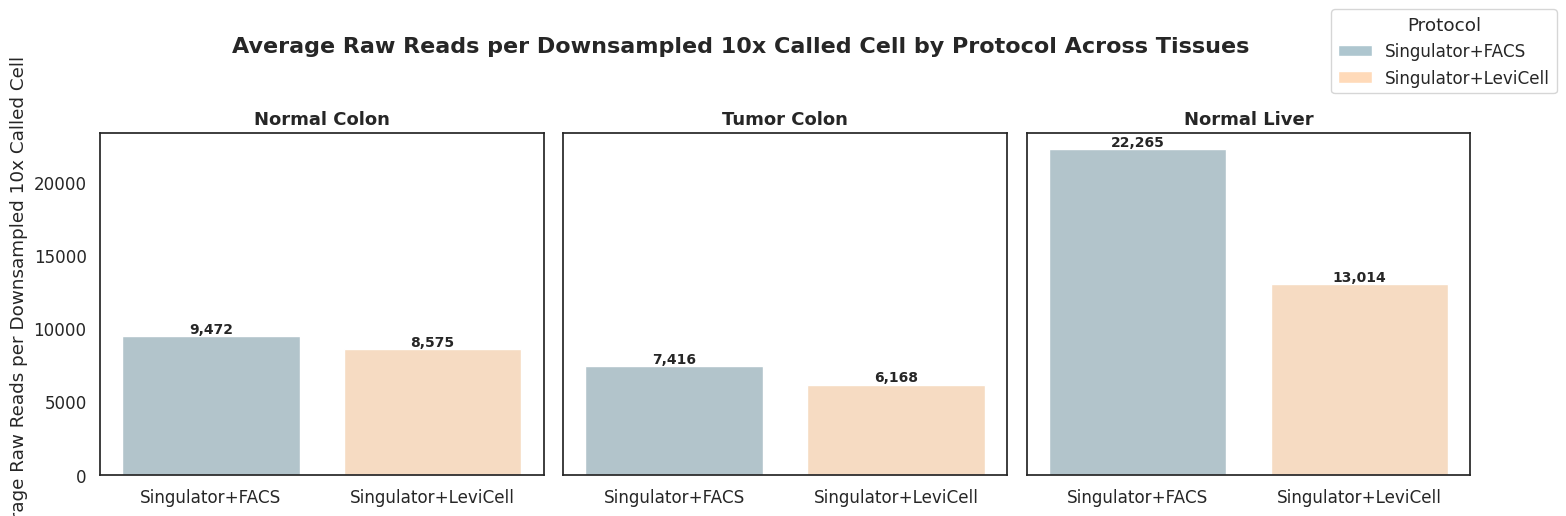

In [21]:
# Plot the total reads per sample for all filtered cells
fig = utils.plot_scalar_metric(
    data_dict=downsampled_mol_infos,
    metadata=downsampled_mol_info_metadata,
    metric_func=lambda df: df["reads"].sum()
    / df["cell"].n_unique(),  # Total reads per sample
    metric_label="Average Raw Reads per Downsampled 10x Called Cell",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "average_raw_reads_per_cell.png"),
    bbox_inches="tight",
)

### Plot Number of Cells by Protocol Across Tissues

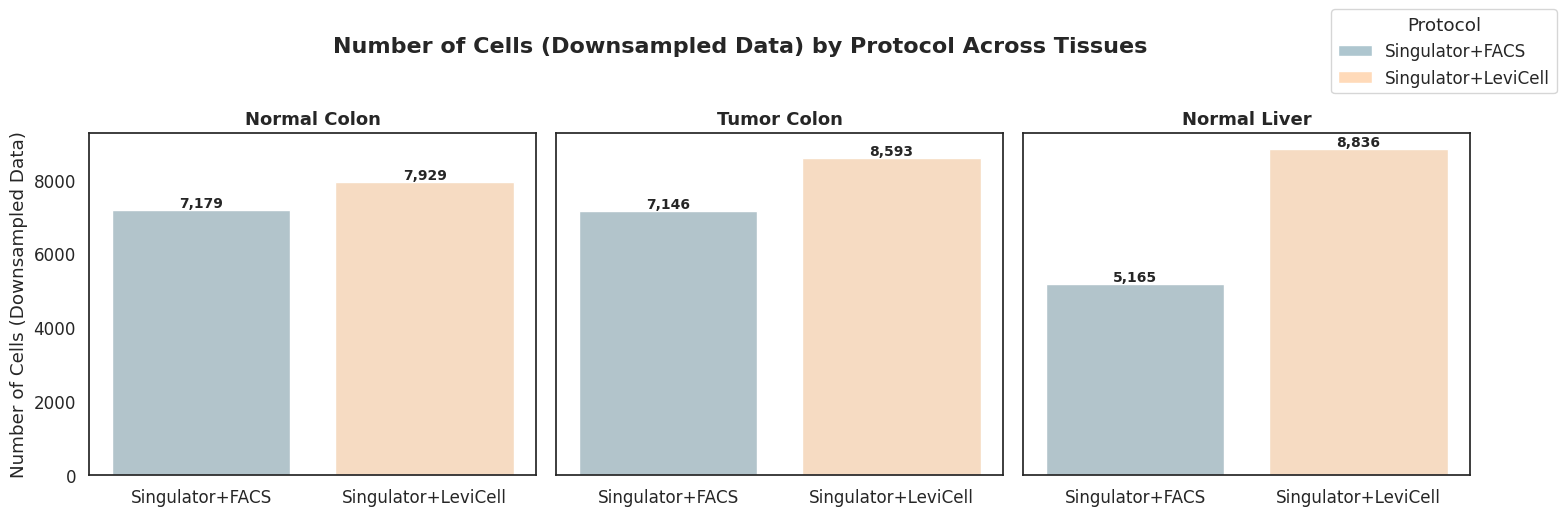

In [22]:
# Plot number of cells
fig = utils.plot_scalar_metric(
    data_dict=adatas,
    metadata=adata_metadata,
    metric_func=lambda adata: adata.n_obs,
    metric_label="Number of Cells (Downsampled Data)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "num_cells.png"), bbox_inches="tight")

### Plot Total UMIs

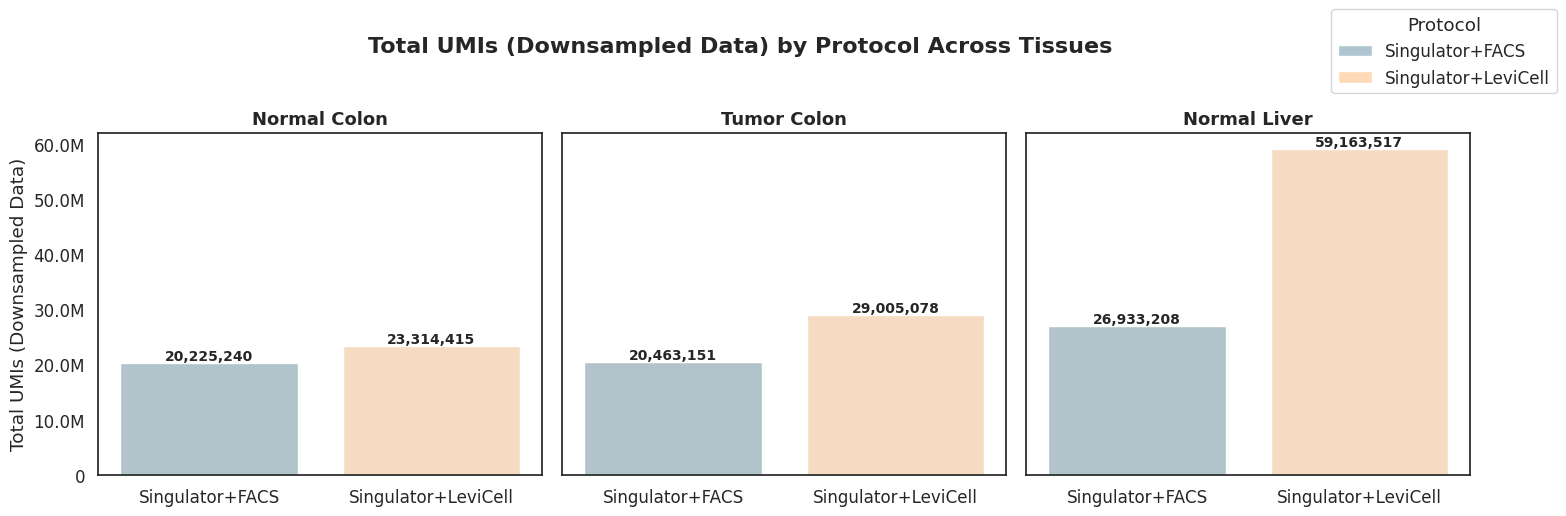

In [23]:
# Plot number of cells
fig = utils.plot_scalar_metric(
    data_dict=adatas,
    metadata=adata_metadata,
    metric_func=lambda adata: adata.X.sum(),
    metric_label="Total UMIs (Downsampled Data)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "total_umis.png"), bbox_inches="tight")

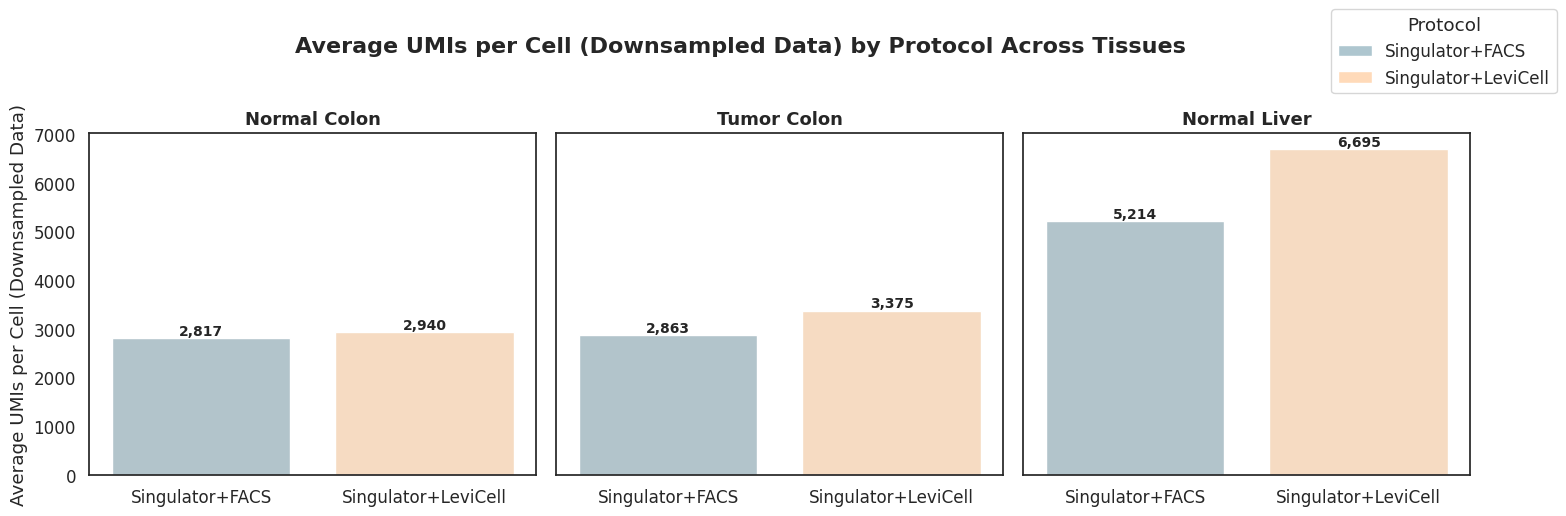

In [24]:
# Plot number of cells
fig = utils.plot_scalar_metric(
    data_dict=adatas,
    metadata=adata_metadata,
    metric_func=lambda adata: adata.X.sum() / adata.n_obs,
    metric_label="Average UMIs per Cell (Downsampled Data)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "average_umis_per_cell.png"), bbox_inches="tight"
)

### Plot Library Size Distribution

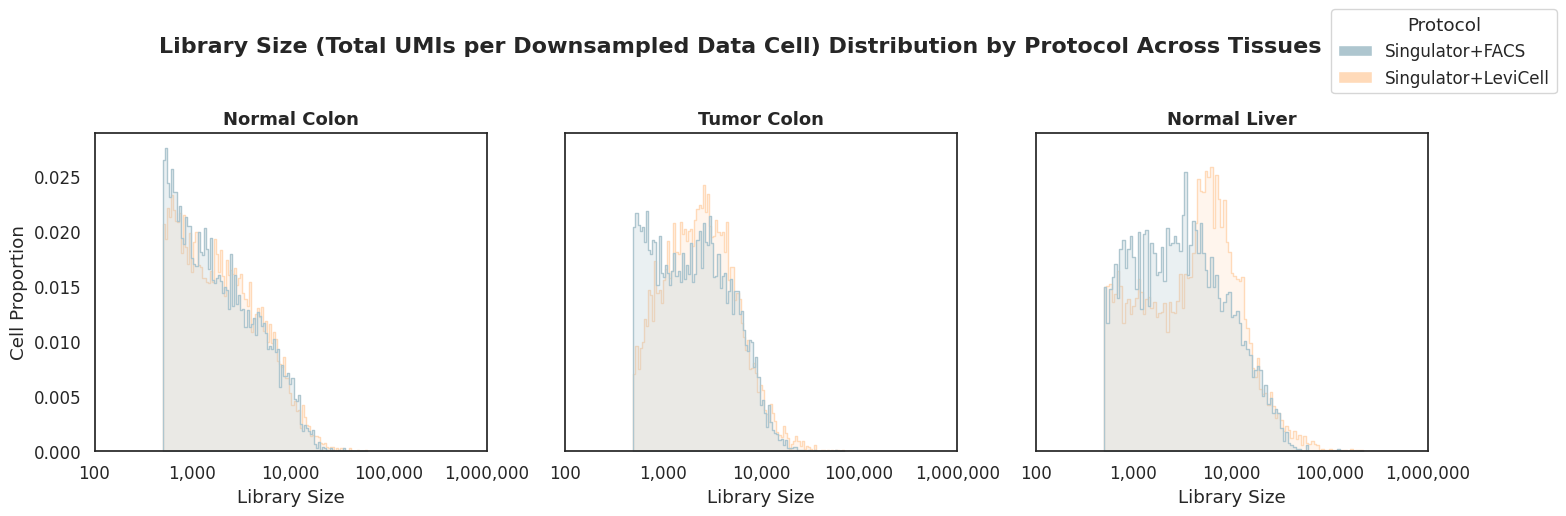

In [25]:
# Plot number of cells
fig = utils.plot_adata_metric_histogram(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="total_counts",
    axis="obs",
    log_x=True,
    x_label="Library Size",
    title="Library Size (Total UMIs per Downsampled Data Cell) Distribution by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "library_size_hist.png"), bbox_inches="tight"
)

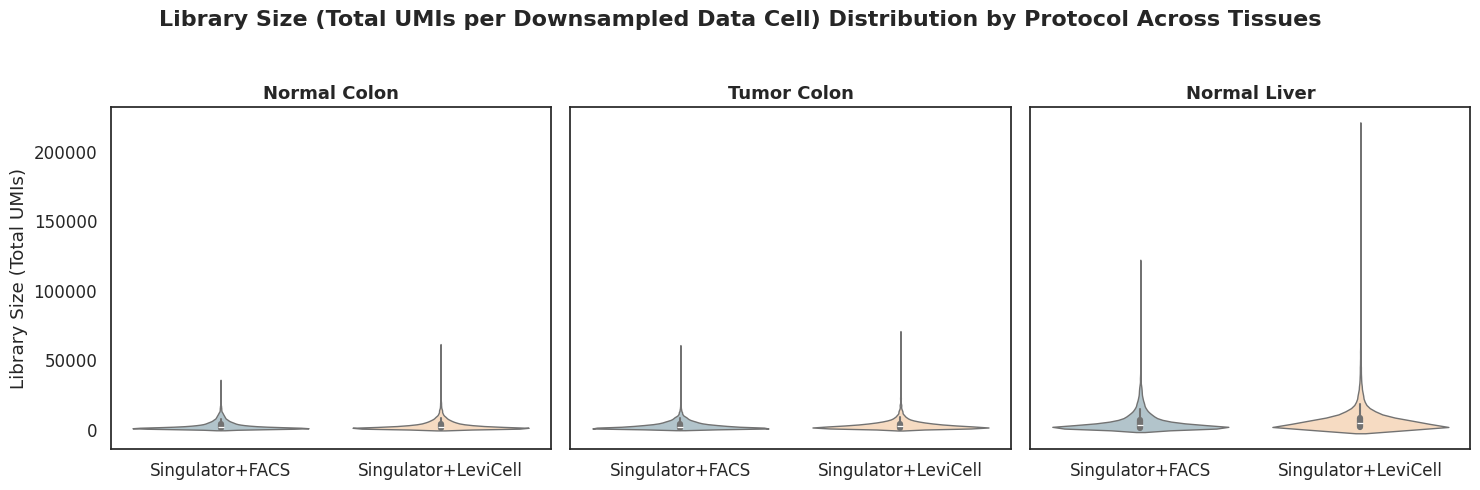

In [26]:
# Plot number of cells
fig = utils.plot_adata_metric_violin(
    adatas,
    adata_metadata=adata_metadata,
    field="total_counts",
    axis="obs",
    y_label="Library Size (Total UMIs)",
    title="Library Size (Total UMIs per Downsampled Data Cell) Distribution by Protocol Across Tissues",
    log_y=False,
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "library_size_violin.png"), bbox_inches="tight"
)

### Plot Number of Genes per Cell

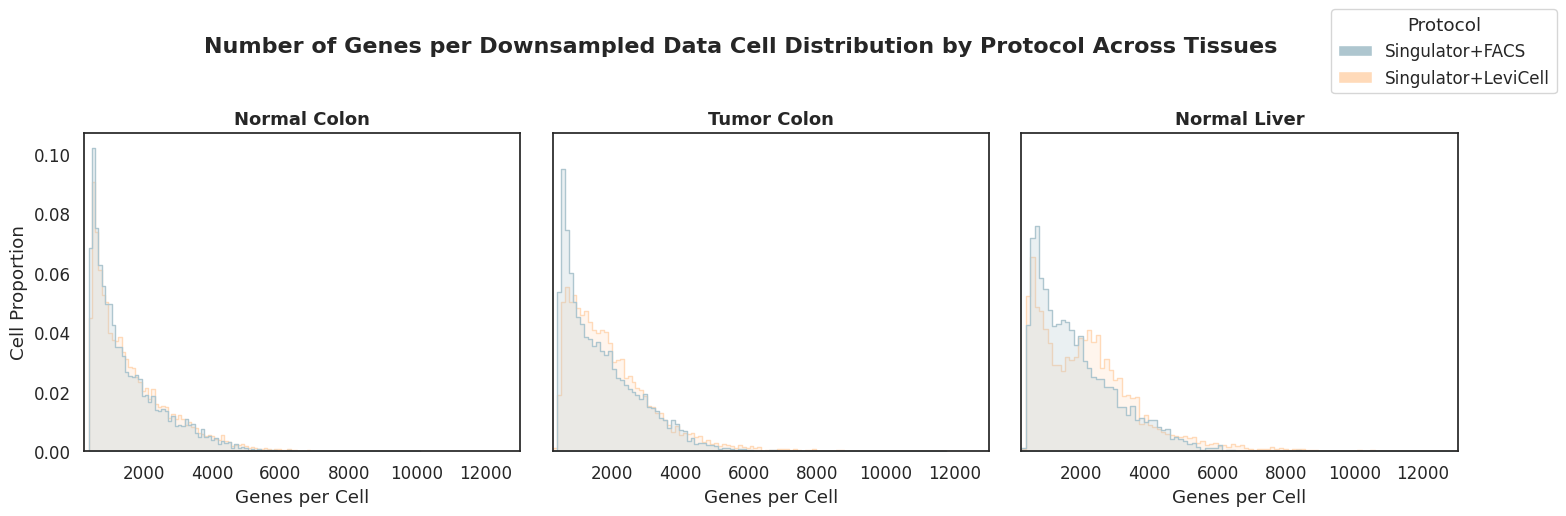

In [27]:
# Plot number of genes per cell
fig = utils.plot_adata_metric_histogram(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="n_genes_by_counts",
    axis="obs",
    log_x=False,
    x_label="Genes per Cell",
    title="Number of Genes per Downsampled Data Cell Distribution by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "genes_per_cell_hist.png"), bbox_inches="tight"
)

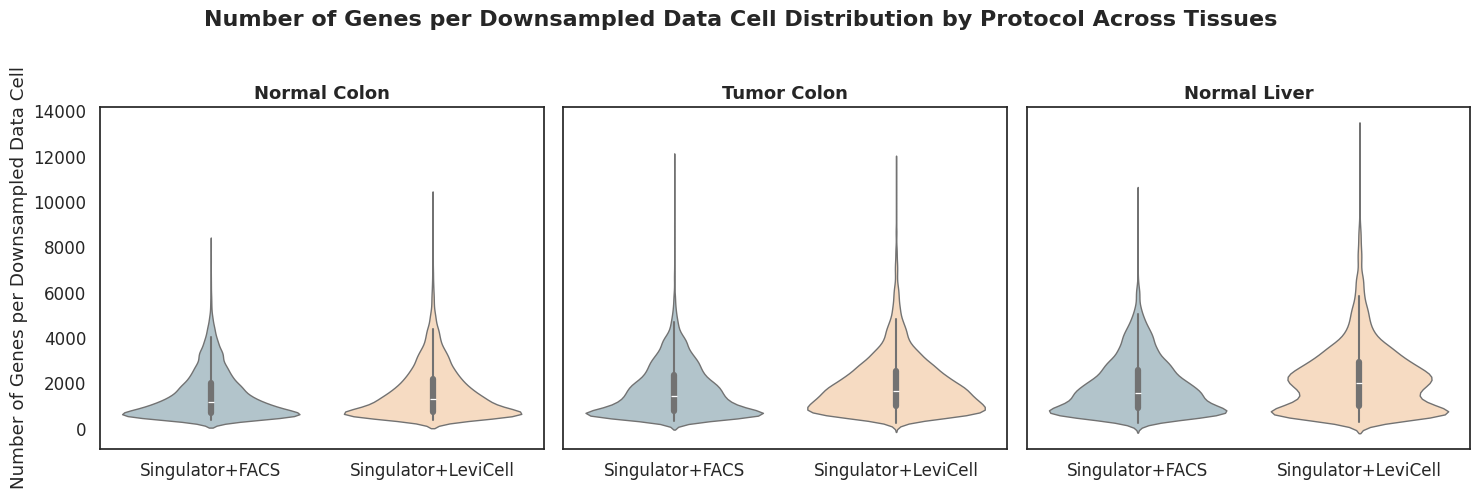

In [28]:
# Plot number of cells
fig = utils.plot_adata_metric_violin(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="n_genes_by_counts",
    axis="obs",
    y_label="Number of Genes per Downsampled Data Cell",
    title="Number of Genes per Downsampled Data Cell Distribution by Protocol Across Tissues",
    log_y=False,
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "genes_per_cell_violin.png"), bbox_inches="tight"
)

### Gene Detection

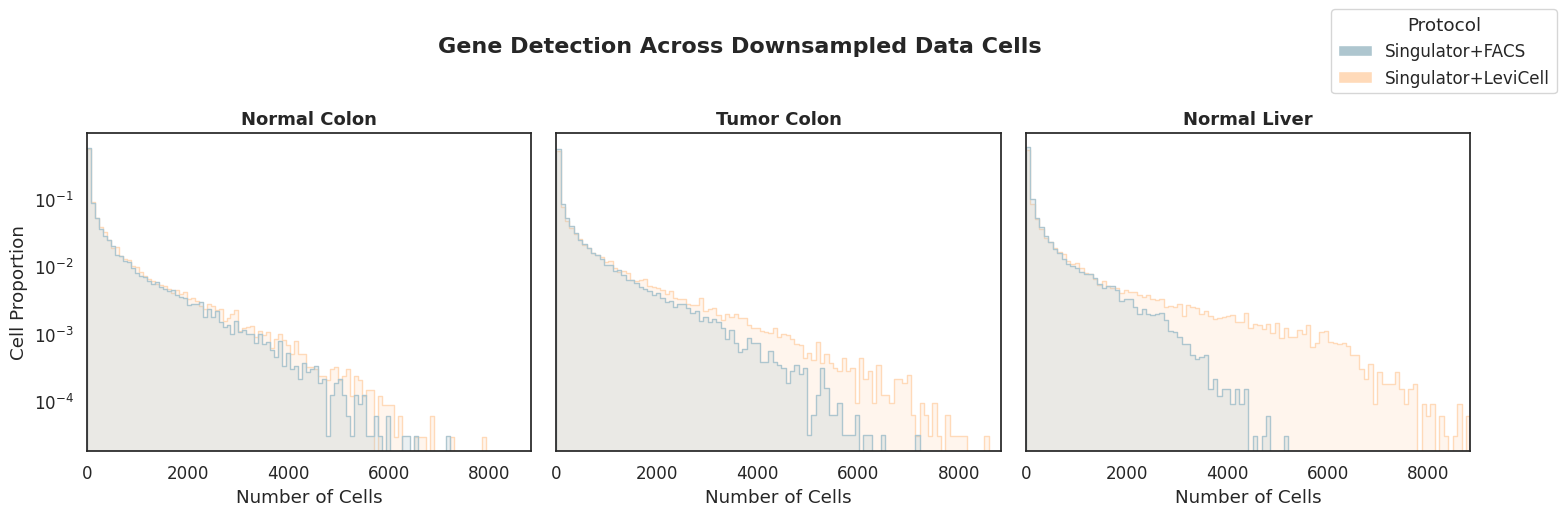

In [29]:
# Plot number of cells per gene
fig = utils.plot_adata_metric_histogram(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="n_cells_by_counts",
    axis="var",
    log_x=False,
    log_y=True,
    x_label="Number of Cells",
    title="Gene Detection Across Downsampled Data Cells",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "gene_detection.png"), bbox_inches="tight")

## Compute Mitochondrial and Ribosomal Gene Count Percentages

#### Compute Gene Percentage Metrics

In [30]:
utils.compute_gene_category_qc_metrics(
    adatas=adatas, category_label="mitochondrial", pattern="MT-"
)
utils.compute_gene_category_qc_metrics(
    adatas=adatas, category_label="ribosomal", pattern=("RPS", "RPL")
)

### Plot Mitochondria Results

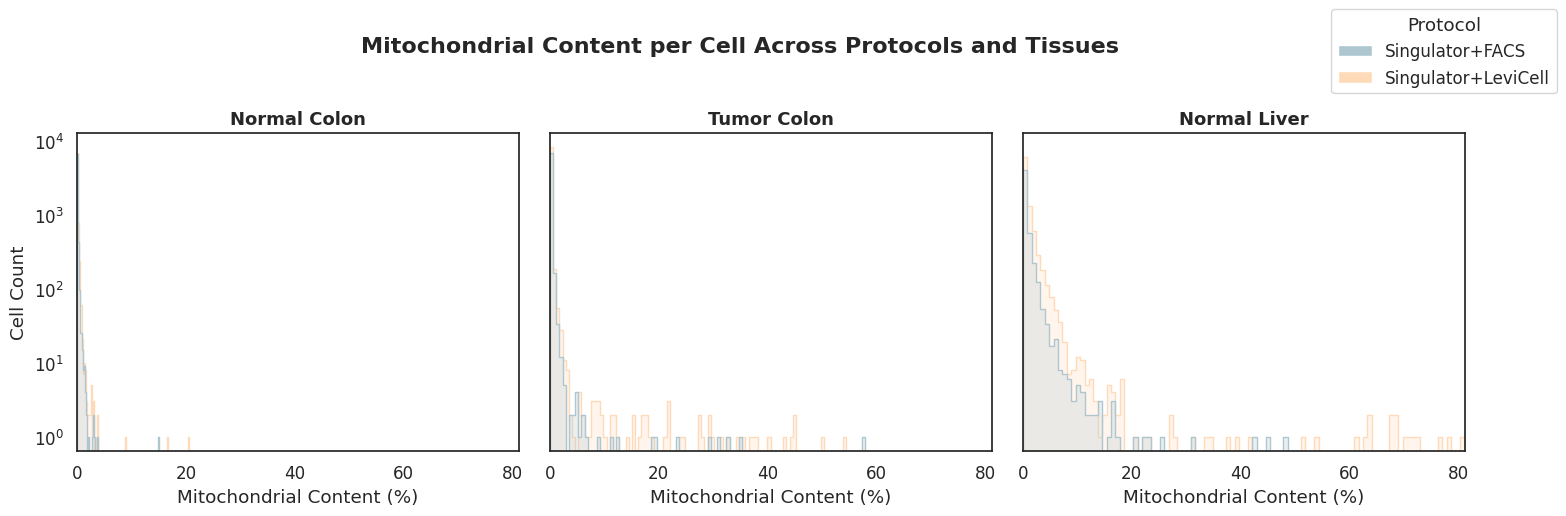

In [31]:
# Plot mitochondrial content percentage
fig = utils.plot_adata_metric_histogram(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_mitochondrial",
    axis="obs",
    log_x=False,
    log_y=True,
    x_label="Mitochondrial Content (%)",
    title="Mitochondrial Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "mitochondrial_percentage_hist.png"),
    bbox_inches="tight",
)

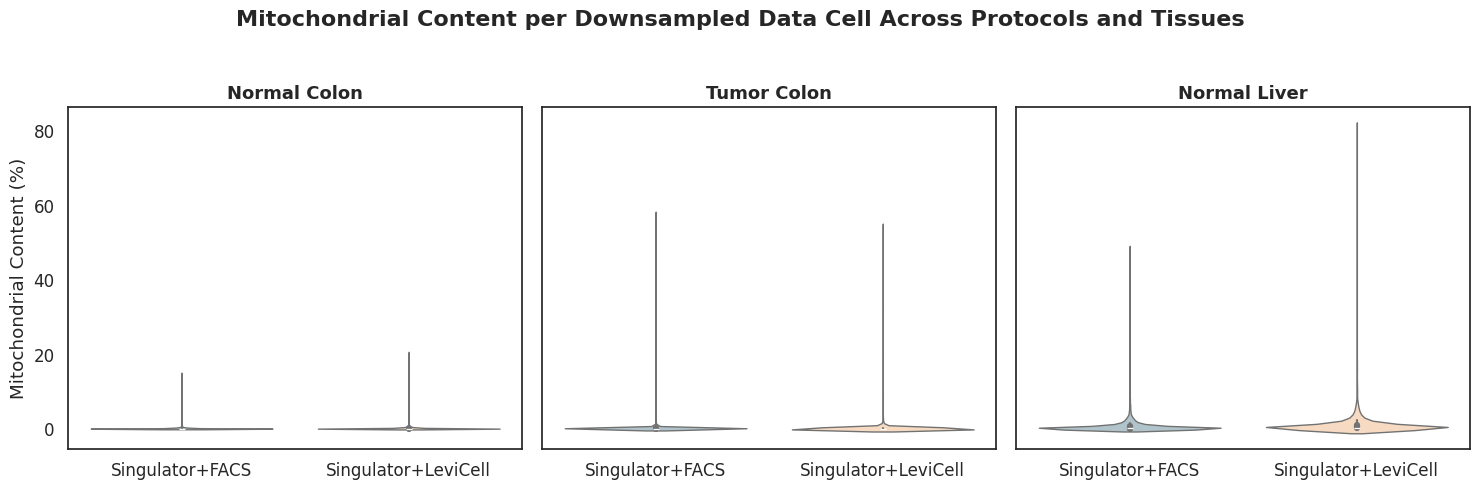

In [32]:
# Plot mitochondrial content percentage
fig = utils.plot_adata_metric_violin(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_mitochondrial",
    axis="obs",
    log_y=False,
    y_label="Mitochondrial Content (%)",
    title="Mitochondrial Content per Downsampled Data Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "mitochondrial_percentage_violin.png"),
    bbox_inches="tight",
)

### Plot Ribosomal Results

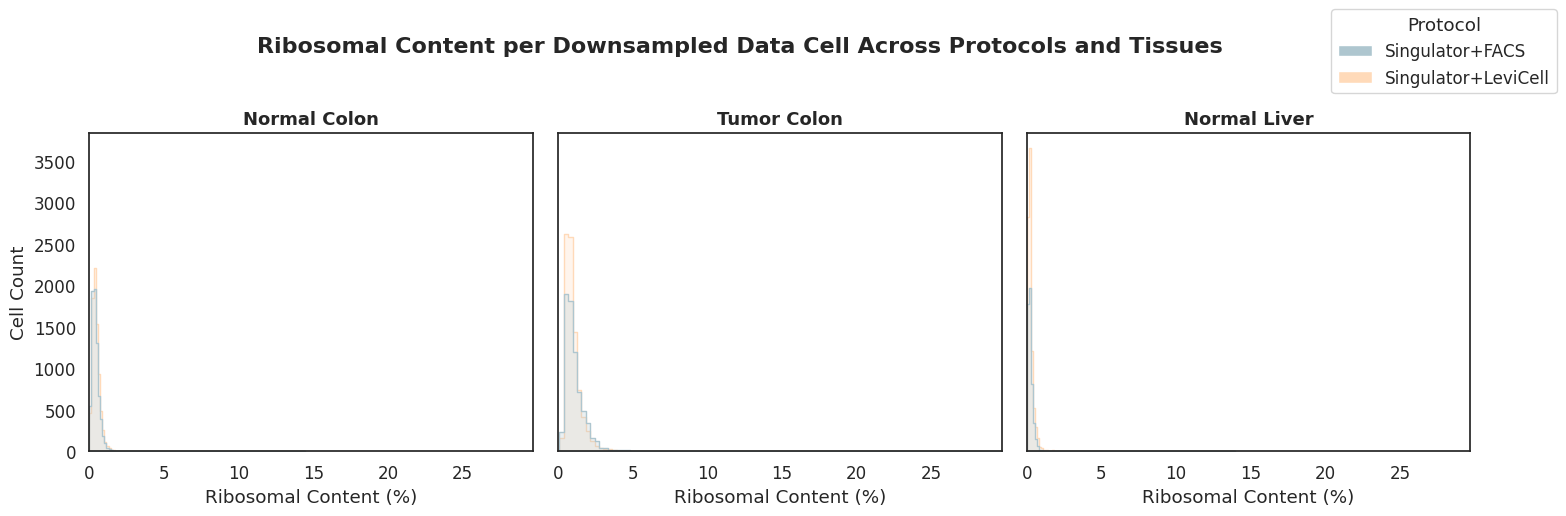

In [33]:
# Plot ribosomal content percentage
fig = utils.plot_adata_metric_histogram(
    adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_ribosomal",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Ribosomal Content (%)",
    title="Ribosomal Content per Downsampled Data Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "ribosomal_percentage_hist.png"),
    bbox_inches="tight",
)

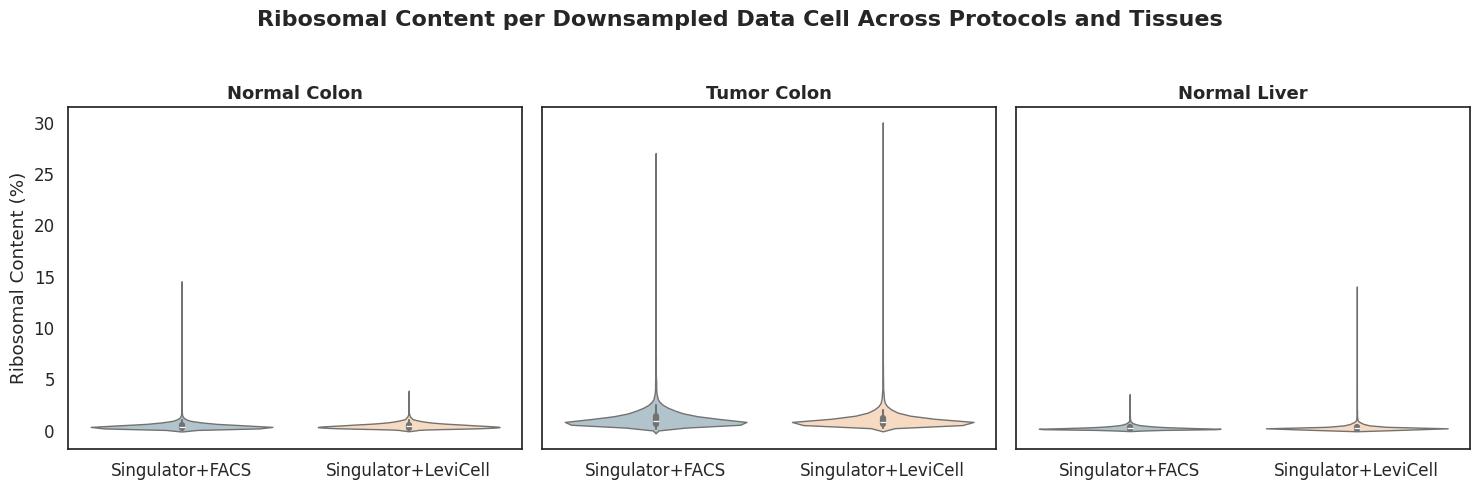

In [34]:
# Plot ribosomal content percentage
fig = utils.plot_adata_metric_violin(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_ribosomal",
    axis="obs",
    log_y=False,
    y_label="Ribosomal Content (%)",
    title="Ribosomal Content per Downsampled Data Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "ribosomal_percentage_violin.png"),
    bbox_inches="tight",
)

## Compare Gene Set Content

### Run functions

In [35]:
# Load apoptosis gene list (from Rahul)
with open(os.path.join(GENE_SETS_DIR, "apoptosis_genes.txt")) as f:
    apoptosis_genes = f.read().splitlines()

# Load housekeeping gene list from (https://www.gsea-msigdb.org/gsea/msigdb/cards/HOUNKPE_HOUSEKEEPING_GENES)
with open(os.path.join(GENE_SETS_DIR, "housekeeping_genes.txt")) as f:
    housekeeping_genes = f.read().splitlines()

# Annotate and compute
utils.add_gene_set_content_to_adatas(adatas, apoptosis_genes, gene_set_name="apoptosis")
utils.add_gene_set_content_to_adatas(
    adatas, housekeeping_genes, gene_set_name="housekeeping"
)

7179 cells | 156 apoptosis genes found
7929 cells | 158 apoptosis genes found
7146 cells | 157 apoptosis genes found
8593 cells | 158 apoptosis genes found
5165 cells | 158 apoptosis genes found
8836 cells | 158 apoptosis genes found
7179 cells | 1129 housekeeping genes found
7929 cells | 1129 housekeeping genes found
7146 cells | 1129 housekeeping genes found
8593 cells | 1129 housekeeping genes found
5165 cells | 1129 housekeeping genes found
8836 cells | 1129 housekeeping genes found


### Plot Apoptosis Results

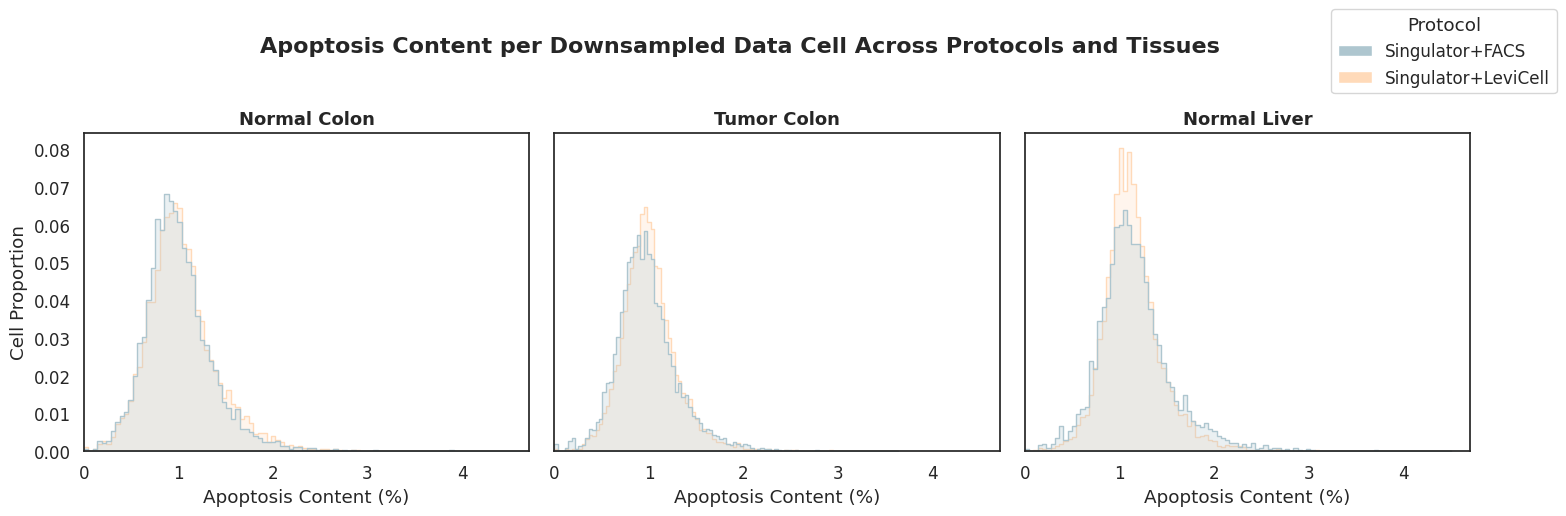

In [36]:
# Plot apoptosis content percentage
fig = utils.plot_adata_metric_histogram(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_apoptosis",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Apoptosis Content (%)",
    title="Apoptosis Content per Downsampled Data Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "apoptosis_percentage_hist.png"),
    bbox_inches="tight",
)

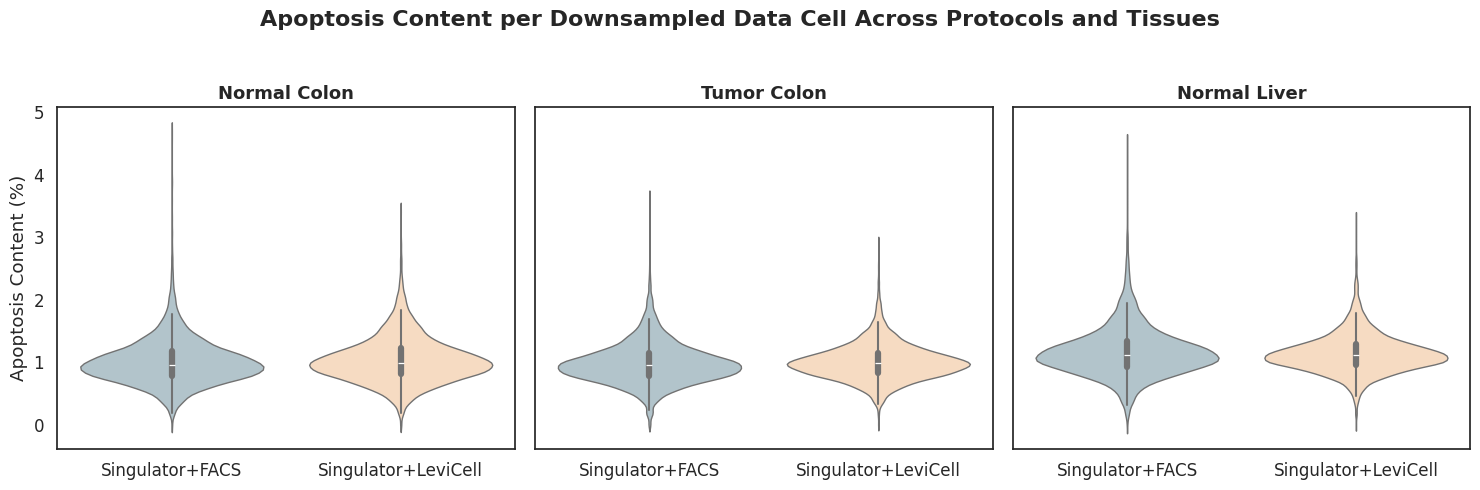

In [37]:
# Plot apoptosis content percentage
fig = utils.plot_adata_metric_violin(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_apoptosis",
    axis="obs",
    log_y=False,
    y_label="Apoptosis Content (%)",
    title="Apoptosis Content per Downsampled Data Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "apoptosis_percentage_violin.png"),
    bbox_inches="tight",
)

### Plot Housekeeping Results

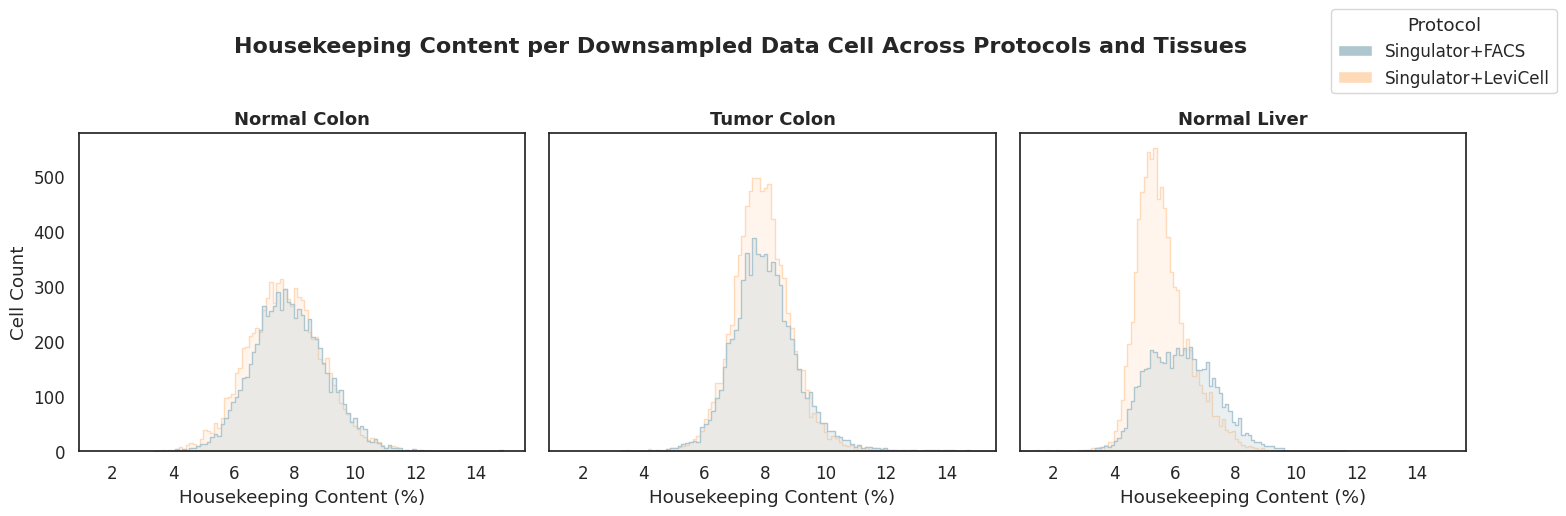

In [38]:
# Plot housekeeping content percentage
fig = utils.plot_adata_metric_histogram(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_housekeeping",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Housekeeping Content (%)",
    title="Housekeeping Content per Downsampled Data Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "housekeeping_percentage_hist.png"),
    bbox_inches="tight",
)

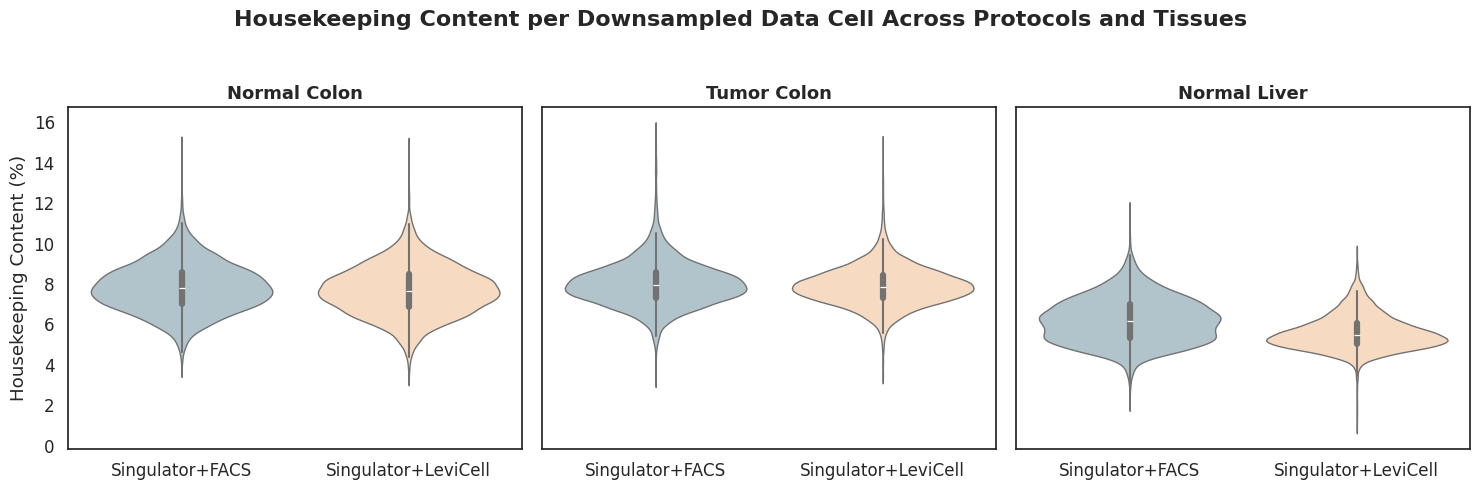

In [39]:
# Plot housekeeping content percentage
fig = utils.plot_adata_metric_violin(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_housekeeping",
    axis="obs",
    log_y=False,
    y_label="Housekeeping Content (%)",
    title="Housekeeping Content per Downsampled Data Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "housekeeping_percentage_violin.png"),
    bbox_inches="tight",
)

## Save AnnDatas to File

In [40]:
# Save each AnnData object to file in the analysis directory
for key, (folder, tissue, protocol) in samples.items():
    out_path = os.path.join(OUTPUT_ADATA_DIR, f"{key}_adata.h5ad")
    adatas[key].write(out_path)
    print(f"Saved {key}_adata to {out_path}")

Saved SF_N_adata to ./data/analysis/adatas/adatas_X_downsampled_with_gene_metrics/SF_N_adata.h5ad
Saved SL_N_adata to ./data/analysis/adatas/adatas_X_downsampled_with_gene_metrics/SL_N_adata.h5ad
Saved SF_T_adata to ./data/analysis/adatas/adatas_X_downsampled_with_gene_metrics/SF_T_adata.h5ad
Saved SL_T_adata to ./data/analysis/adatas/adatas_X_downsampled_with_gene_metrics/SL_T_adata.h5ad
Saved SF_LN_adata to ./data/analysis/adatas/adatas_X_downsampled_with_gene_metrics/SF_LN_adata.h5ad
Saved SL_LN_adata to ./data/analysis/adatas/adatas_X_downsampled_with_gene_metrics/SL_LN_adata.h5ad
